# Learn to Rank
https://www.tensorflow.org/ranking/tutorials/quickstart

https://www.geeksforgeeks.org/train-a-model-using-lightgbm/#
https://gist.github.com/darcyabjones/ace0934ae19c56ed4babc50167f282b0#file-ltr_presentation-ipynb
https://hav4ik.github.io/learning-to-rank/

In [861]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from spacy.tokens import Doc
import csv
import altair as alt

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [862]:
# sentiment analysis
# Doc.set_extension("sentimenter",getter=sentiment_scores)
sent_analyzer = SentimentIntensityAnalyzer()
def sentiment_scores(docx):
    global sent_analyzer
    return sent_analyzer.polarity_scores(docx.text)

def sentiment_analysis(input:str):
    global sent_analyzer
    # set the sentiment analysis functions

    
    nlp = spacy.load("en_core_web_sm")
    return(nlp(input)._.sentimenter['compound'])

In [863]:
# load up full data -- uncomment this if you need to start over with sentiment analysis
# complete = pd.read_csv('https://scmcqueen.github.io/StarTrekScriptData/complete_data.csv').reset_index()
# complete.columns = ['index','line','character', 'quote', 'scene', 'location', 'view',
#        'episode', 'date', 'series', 'file']
# complete['quote']=complete['quote'].apply(lambda text: " ".join(text.split()))
# complete['character']=complete['character'].fillna('NA')
# complete['character']=complete['character'].apply(lambda x: x.replace('"','').replace('\t',''))
# complete['sentiment']=complete.quote.apply(lambda x: 0)
# complete.to_csv('complete_sentiment.csv')
complete = pd.read_csv('complete_sentiment.csv')

In [866]:
# load up ratings
ratings = pd.read_csv('skyeler_ranking_data.csv',index_col=0)


In [868]:
# now we need to merge them

# drop the quote & unnamed 0
ratings.drop(columns=['Unnamed: 0','quote'],inplace=True)
ratings.columns = ['index','query','ranking']
ratings.ranking = ratings.ranking.apply(lambda z: ratings.ranking.max()+1 if z < 0 else z)
full_data = ratings.merge(complete,on=['index'],how='left')

In [871]:
full_data['character'] = full_data['character'].fillna('')
complete['character'] = complete['character'].fillna('')

In [872]:
# feature engineering
full_data['quote_len']=full_data['quote'].apply(lambda z: len(z.split()))

quote_count = complete.groupby('character').count()['quote']


full_data['total_quotes_char']=full_data['character'].apply(lambda x: quote_count[x])


In [ ]:
full_data.drop(columns=['Unnamed: 0.1','Unnamed: 0'],inplace=True)
full_data.head()

,index,query,ranking,line,character,quote,scene,location,view,episode,date,series,file,sentiment,quote_len,total_quotes_char
0,113689,lwaxana,21,355,TIMICIN,Lwaxana... ?,93 INT. TRANSPORTER ROOM,TRANSPORTER ROOM,INT.,Half a Life,1991-02-22,The Next Generation,196.txt,0.0,2,105
1,113558,lwaxana,21,224,TIMICIN,Lwaxana...,63 INT. TIMICIN'S QUARTERS,TIMICIN'S QUARTERS,INT.,Half a Life,1991-02-22,The Next Generation,196.txt,0.0,1,105
2,113532,lwaxana,21,198,TIMICIN,Lwaxana...,63 INT. TIMICIN'S QUARTERS,TIMICIN'S QUARTERS,INT.,Half a Life,1991-02-22,The Next Generation,196.txt,0.0,1,105
3,55180,lwaxana,21,284,ODO,Lwaxana... ?,35 INT. ODO'S QUARTERS,ODO'S QUARTERS,INT.,The Muse,1996-02-13,Deep Space Nine,493.txt,0.0,2,4993
4,55060,lwaxana,21,164,ODO,Lwaxana... ?,20 INT. ODO'S QUARTERS,ODO'S QUARTERS,INT.,The Muse,1996-02-13,Deep Space Nine,493.txt,0.0,2,4993


In [879]:
# train test split my data
train, test = train_test_split(full_data,test_size=.15,random_state=56)
# sort my train values
train = train.sort_values('query')
test = test.sort_values('query')

In [880]:
train_y = list(train['ranking']) # made a list instead of series
train_X = train.drop(columns=['query','ranking','quote','date','scene','index'])
groups = train['query'].value_counts().reset_index().sort_values('query')['count'].values

In [881]:
train_X.sample(2)

,line,character,location,view,episode,series,file,sentiment,quote_len,total_quotes_char
601,156,CH'TARGH,BIRD OF PRE,INT.,Sons and Daughters,Deep Space Nine,526.txt,0.4939,4,21
1883,249,BAREIL,TEMPLE GARDE,EXT.,The Circle,Deep Space Nine,422.txt,0.0000,4,366


In [882]:
num_attribs = list(train_X.select_dtypes(include=[np.number]))  # bill length, bill depth, body mass
cat_attribs = list(train_X.select_dtypes(exclude=[np.number]))  # species, island, sex

# takes in sequence of tuples
full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),   # scales the numerical attributes down!
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),    # turns the categorical term into a vector
    ])

train_prep = full_pipeline.fit_transform(train_X)


In [883]:
num_names = full_pipeline.named_transformers_["num"].get_feature_names_out(num_attribs)
cat_names = full_pipeline.named_transformers_["cat"].get_feature_names_out(cat_attribs)
total_names = list(num_attribs)+list(cat_names)

In [884]:
test_y = list(test['ranking'])
test_X = test.drop(columns=['query','ranking','quote','date','scene','index'])
t_groups = test['query'].value_counts().reset_index().sort_values('query')['count'].values
test_prep = full_pipeline.transform(test_X)

In [885]:
train_data =lgb.Dataset(train_prep, label=train_y, group=groups,params={'min_data_in_leaf':1})
valid_data = lgb.Dataset(test_prep,label=test_y,group=t_groups)

In [886]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.01,
    'num_leaves': 19, # 31
    'task':'train',
    # 'feature_pre_filter':False,
    "num_leaves": 255,
    "feature_pre_filter": False,
#   "min_data_in_leaf": 1,
    'max_depth':40,
    'verbose':-1
    # 'max_depth':-1
}
res = {}

In [887]:
ranker = lgb.train(params, train_data, num_boost_round=250,valid_sets=[valid_data])

In [888]:
type(ranker)

lightgbm.basic.Booster

In [889]:
ranker.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('ndcg@1', 0.80817897690426),
                          ('ndcg@2', 0.8384754015552984),
                          ('ndcg@3', 0.8844535193089901),
                          ('ndcg@4', 0.9002724048457645),
                          ('ndcg@5', 0.9125589041027111)])})

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

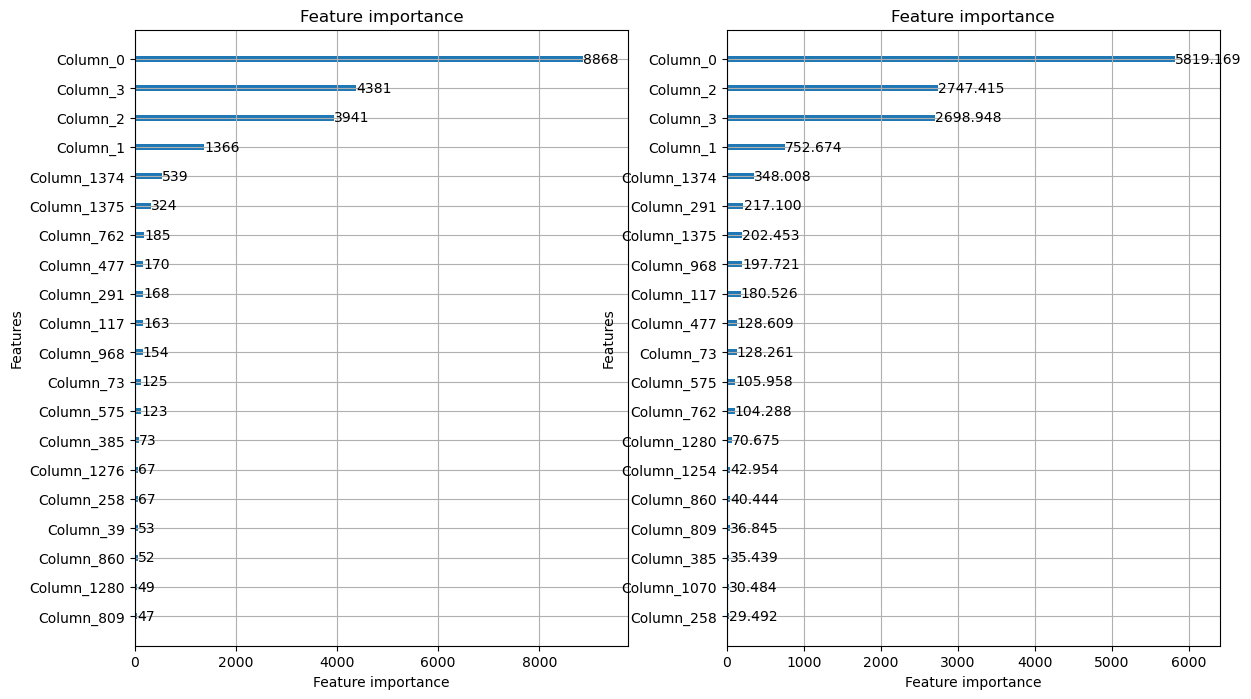

In [890]:
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
lgb.plot_importance(ranker, importance_type='split', ax=ax[0], max_num_features=20)
lgb.plot_importance(ranker, importance_type='gain', ax=ax[1], max_num_features=20)

In [891]:
# Top Features
total_names[0], total_names[3], total_names[2], total_names[1],total_names[1374],total_names[1375], total_names[762]

('line',
 'total_quotes_char',
 'quote_len',
 'sentiment',
 'series_Deep Space Nine',
 'series_The Next Generation',
 'location_MAIN BRIDGE')

### I built a ranker model!

My simple, starting model has been built. The most important features were the line number in the episode ('line'), the total quotes a character has across both series, the length of the quote, the series, and whether the speaker is Riker.

Now, I want to functionize this process and add even more features.

# More Learning2Rank

More ideas: Lines per episode, lines per series, sentiment analysis.

In [892]:
# read in completed sent data
with open("sent_map.csv", mode="r") as file:
    reader = csv.DictReader(file)
    sent_data = [row for row in reader][0]  # List of dictionaries

sent_data={int(k):float(v) for k,v in sent_data.items()}

def get_sentiment_analysis(indices:list,complete:pd.DataFrame,sent_data:dict):
    output = {}
    for x in indices:
        if x in sent_data.keys():
            output[x]=sent_data[x]
            continue
        row = complete.iloc[x]
        if row['sentiment']==0:
            sent = sentiment_analysis(row['quote'])
            print(row['quote'],sent)
            output[x]=sent
    for x in indices:
        y = x+1
        if y in sent_data.keys():
            output[y]=sent_data[y]
            continue
        row = complete.iloc[y]
        if row['sentiment']==0:
            sent = sentiment_analysis(row['quote'])
            print(row['quote'],sent)
            output[y]=sent
    for x in indices:
        z=x-1
        if z in sent_data.keys():
            output[z]=sent_data[z]
            continue
        row = complete.iloc[z]
        if row['sentiment']==0:
            sent = sentiment_analysis(row['quote'])
            print(row['quote'],sent)
            output[z]=sent
    return(output)

In [893]:
sentiment_map = get_sentiment_analysis([x for x in ratings['index']],complete,sent_data)
with open("sent_map_2.csv", "w", newline="") as f:
    w = csv.DictWriter(f, sentiment_map.keys())
    w.writeheader()
    w.writerow(sentiment_map)

/opt/anaconda3/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Lwaxana... ? 0.0
Lwaxana... 0.0
Lwaxana... 0.0
Lwaxana... ? 0.0
Lwaxana... ? 0.0
Lwaxana... 0.0
Lwaxana, don't. 0.0
Deanna? Lwaxana? 0.0
Please... Lwaxana... 0.0
I meant Lwaxana. 0.0
Marry me, Lwaxana... 0.0
Goodnight, Lwaxana. 0.0
He is with Lwaxana Troi. 0.0
Lwaxana Troi, I desire you. 0.4019
Lwaxana... Upper pylon three. 0.0
But you'll destroy Lwaxana! -0.722
Lwaxana Troi... the ambassador... ? 0.0
Lwaxana isn't just any woman. 0.0
Helping... trying to help Lwaxana... 0.4019
I think he's Lwaxana's husband. 0.0
A bucket? 0.0
Inside a bucket? 0.0
You're out of your bucket early today. 0.0
Like putting a fish in a bucket of water... 0.3612
I don't know... We could swipe Odo's bucket. 0.0
I still don't understand what's so funny about a bucket. 0.5777
(on Odo's lack of response) How about a latinum plated bucket to sleep in? -0.3182
I'm not sure either. And that's... unfortunate. Now, if you'll excuse me I have to return to my bucket. -0.5664
Maybe so... but when they can build a ship l

In [895]:
complete['sentiment']=complete['index'].apply(lambda x: sentiment_map[x] if x in sentiment_map.keys() else 0)
complete.to_csv('complete_sentiment.csv')

complete_sent = complete.copy()

In [896]:
def preprocess_data(complete_data:pd.DataFrame,ratings:pd.DataFrame)->dict:
    '''Pre-processes the ranking data.

    Returns training data & validation data
    '''
    print('start')
    complete = complete_data.copy()
    output = {} # initialize output dict

    # fill NAN characters
    complete['character']=complete['character'].fillna('')

    print('dropping old columns')
    # drop unneeded columns
    ratings.drop(columns=['Unnamed: 0','quote'],inplace=True)
    ratings.columns = ['index','query','ranking']

    print('Replacing 0 rankings')
    # replace rankings of 0 to max level (1 is highest ranking)
    ratings.ranking = ratings.ranking.apply(lambda z: ratings.ranking.max()+1 if z < 0 else z)

    print('merge data')
    # get the full data & join
    full_data = ratings.merge(complete,on=['index'],how='left')

    #----------------- FEATURE ENGINEERING -----------------
    print('Get quote length')
    # length of quote
    full_data['quote_len']=full_data['quote'].apply(lambda z: len(z.split()))
    # character overall quotes in df
    print('Get total quotes')
    quote_count = complete.groupby('character').count()['quote']
    full_data['total_quotes_char']=full_data['character'].apply(lambda x: quote_count[x])
    # character overall quotes in episode
    print('Get episode quotes')
    ep_quote = complete.groupby(['character','file']).count()['quote']
    full_data['episode_quotes']=full_data.apply(lambda x: ep_quote[x['character'],x['file']],axis=1)
    # previous quote info
    print('Get previous quote')
    complete['prev_character']=complete['character'].shift(1)
    complete['prev_sent']=complete['sentiment'].shift(1)
    complete['prev_quote_len']=complete['quote'].apply(lambda z: len(str(z).split())).shift(1)
    full_data = pd.merge(full_data,complete[['prev_character','prev_quote_len','prev_sent','index']],on='index',how='left')
    # next quote info
    complete['next_character']=complete['character'].shift(-1)
    complete['next_sent']=complete['sentiment'].shift(-1)
    complete['next_quote_len']=complete['quote'].apply(lambda z: len(str(z).split())).shift(-1)
    full_data = pd.merge(full_data,complete[['next_character','next_quote_len','next_sent','index']],on='index',how='left')
    return(full_data)

In [897]:
def get_training_data(full_data:pd.DataFrame,drop_cols:list=['query','ranking','quote','date','scene','index','Unnamed: 0']):
    output ={}
    # split the data
    train, test = train_test_split(full_data,test_size=.2,random_state=56)
    # sort the data, for the groups
    train = train.sort_values('query')
    test = test.sort_values('query')
    # create the train labels, data, + group
    output['train_y'] = list(train['ranking']) # made a list instead of series
    output['train_X'] = train.drop(columns=drop_cols)
    output['train_groups'] = train['query'].value_counts().reset_index().sort_values('query')['count'].values
    # repeat for test
    output['test_y'] = list(test['ranking'])
    output['test_X'] = test.drop(columns=drop_cols)
    output['test_groups'] = test['query'].value_counts().reset_index().sort_values('query')['count'].values

    return(output)

In [898]:
def format_data(output:dict):
    formatted_data = {}
    # return the pipeline
    num_attribs = list(output['train_X'].select_dtypes(include=[np.number]))
    cat_attribs = list(output['train_X'].select_dtypes(exclude=[np.number]))
    # make pipeline
    full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),   # scales the numerical attributes down!
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),    # turns the categorical term into a vector
    ])
    # prepare training_data
    train_prep = full_pipeline.fit_transform(output['train_X'])
    # get names of labels
    num_names = full_pipeline.named_transformers_["num"].get_feature_names_out(num_attribs)
    cat_names = full_pipeline.named_transformers_["cat"].get_feature_names_out(cat_attribs)
    total_names = list(num_attribs)+list(cat_names)
    # prep test data
    test_prep = full_pipeline.transform(output['test_X'])
    # format for lgbm
    train_data =lgb.Dataset(train_prep, label=output['train_y'], 
        group=output['train_groups'],params={'min_data_in_leaf':1})
    valid_data = lgb.Dataset(test_prep,label=output['test_y'],
        group=output['test_groups'])
    return {
        'pipeline': full_pipeline,
        'train_data':train_data,
        'valid_data':valid_data,
        'pipeline_names':total_names
    }

In [899]:
ratings = pd.read_csv('skyeler_ranking_data.csv',index_col=0)

pp_data=preprocess_data(complete_sent,ratings)

start
dropping old columns
Replacing 0 rankings
merge data
Get quote length
Get total quotes
Get episode quotes
Get previous quote


In [905]:
pp_data.drop(columns=['Unnamed: 0.1','Unnamed: 0'],inplace=True)
# need to fix this eventually

In [906]:
data_sets = get_training_data(pp_data,['query','ranking','quote','date','scene','index'])
formatted_data = format_data(data_sets)

In [911]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.01,
    'num_leaves': 19, # 31
    'task':'train',
    "num_leaves": 255,
    "feature_pre_filter": False,
    'max_depth':40,
    'verbose':-1
}
evals={}

ranker = lgb.train(params, formatted_data['train_data'], num_boost_round=3000,
valid_sets=[formatted_data['valid_data']],callbacks = [lgb.record_evaluation(evals)])

print(ranker.best_score)

defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict({'ndcg@1': 0.793751962840722, 'ndcg@2': 0.8091683297873348, 'ndcg@3': 0.8413265123005601, 'ndcg@4': 0.8664866343272322, 'ndcg@5': 0.8823537036941294})})


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

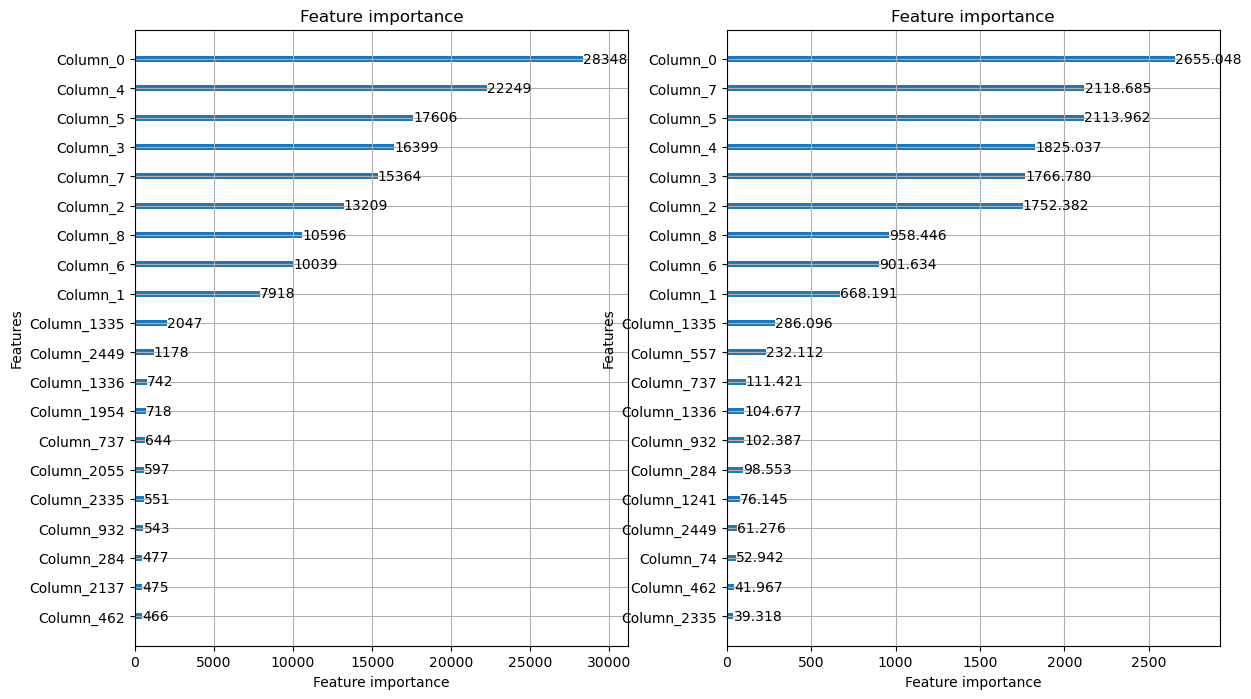

In [912]:
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
lgb.plot_importance(ranker, importance_type='split', ax=ax[0], max_num_features=20)
lgb.plot_importance(ranker, importance_type='gain', ax=ax[1], max_num_features=20)

In [913]:
# Top Features
formatted_data['pipeline_names'][0],formatted_data['pipeline_names'][4],formatted_data['pipeline_names'][5],formatted_data['pipeline_names'][3],formatted_data['pipeline_names'][7],formatted_data['pipeline_names'][2],formatted_data['pipeline_names'][8],formatted_data['pipeline_names'][6],formatted_data['pipeline_names'][1]

('line',
 'episode_quotes',
 'prev_quote_len',
 'total_quotes_char',
 'next_quote_len',
 'quote_len',
 'next_sent',
 'prev_sent',
 'sentiment')

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/plotting.py:382: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='ndcg@5'>

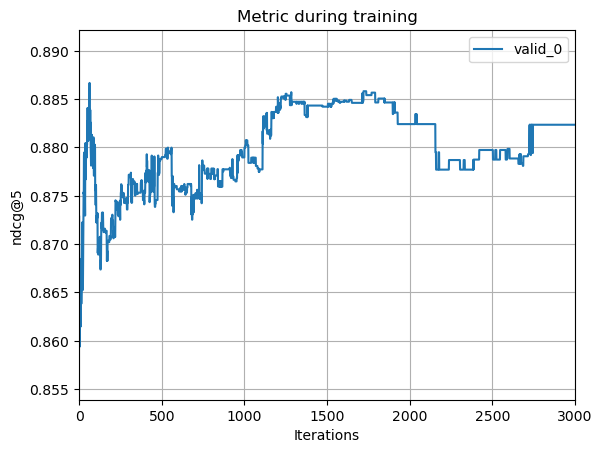

In [914]:
lgb.plot_metric(evals)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

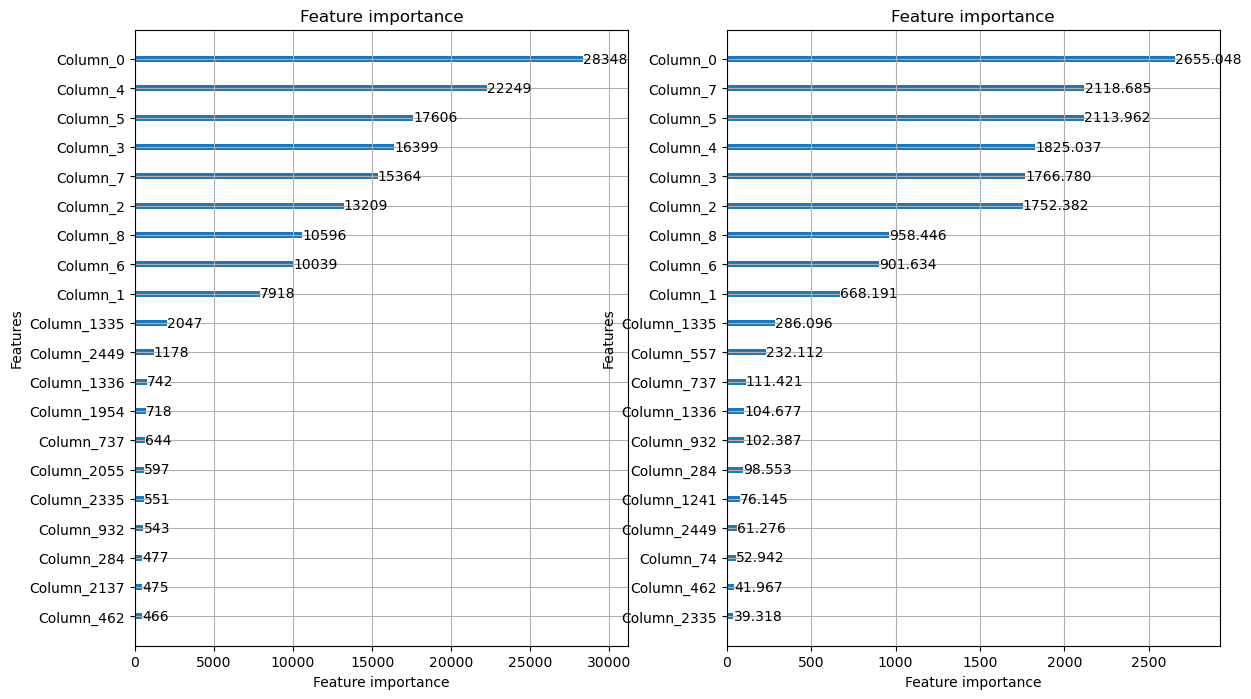

In [915]:
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
lgb.plot_importance(ranker, importance_type='split', ax=ax[0], max_num_features=20)
lgb.plot_importance(ranker, importance_type='gain', ax=ax[1], max_num_features=20)

defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict({'ndcg@1': 0.7387617584722365, 'ndcg@2': 0.7857197400837034, 'ndcg@3': 0.8355769592120924, 'ndcg@4': 0.8548630913419727, 'ndcg@5': 0.8740560242744239})})


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/plotting.py:382: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


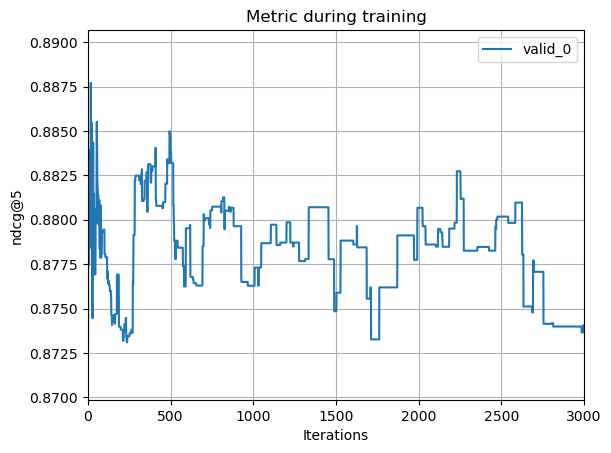

In [916]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.00001,
    'num_leaves': 31, # 31
    'task':'train',
    "num_leaves": 255,
    "feature_pre_filter": False,
    'max_depth':40,
    'verbose':-1
}
evals={}

ranker = lgb.train(params, formatted_data['train_data'], num_boost_round=3000,
valid_sets=[formatted_data['valid_data']],callbacks = [lgb.record_evaluation(evals)])
lgb.plot_metric(evals)

print(ranker.best_score)

In [918]:
eval_df

,iterations,variable,value
0,0,1,0.788248
1,1,1,0.827223
2,2,1,0.806642
3,3,1,0.788432
4,4,1,0.811758
...,...,...,...
14995,2995,5,0.882429
14996,2996,5,0.882429
14997,2997,5,0.882429
14998,2998,5,0.882429


In [919]:
# pd.melt(eval_df,id_vars='iterations')

In [920]:
eval_data = {'1':evals['valid_0']['ndcg@1'],
            '2':evals['valid_0']['ndcg@2'],
            '3':evals['valid_0']['ndcg@3'],
            '4':evals['valid_0']['ndcg@4'],
            '5':evals['valid_0']['ndcg@5'],
            'iterations':list(range(3000))}

eval_df = pd.DataFrame(eval_data)
eval_df = pd.melt(eval_df,id_vars='iterations')

colors = ['#3bd47c','#3C91E6','#000000','#0C0A3E','#8A2BE2']

In [921]:
temp = alt.Chart(eval_df).mark_line(
    ).encode(
        x=alt.X('iterations',title='Model Iterations',scale=alt.Scale(domain=[0,3000])),
        y=alt.Y('value',title='Normalized Discounted Cumulative Gain',scale=alt.Scale(domain=[.6,1])),
        color = alt.Color('variable',title='Truncation Level').scale(range=colors)
    ).properties(
        width=600,
        height=300,
        title='LambdaRank Model Results'
    )

temp # ,values=[0,500,1000,1500,2000,2500,3000]

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [922]:
# I want to be able to get the sum of the feature importance for the features that were one-hot encoded
def get_cumulative_feature_importance(model:lgb.basic.Booster,column_names:list)-> pd.DataFrame:
    importance_list = model.feature_importance()
    column_groups = column_names[:9] + [x[:x.rindex('_')] if '_' in x else x for x in column_names[9:]]
    importance_df = pd.DataFrame([column_groups,column_names,importance_list], index=['Group', 'Feature','Importance']).T
    return(importance_df)

In [923]:
#get_cumulative_feature_importance(ranker,names).sort_values('Importance',ascending=False).head(20)
get_cumulative_feature_importance(ranker,names).groupby(['Group'])['Importance'].sum().reset_index().sort_values('Importance',ascending=False)

,Group,Importance
4,line,55918
2,episode_quotes,35840
15,total_quotes_char,26659
12,quote_len,22363
10,prev_quote_len,21988
7,next_quote_len,21352
8,next_sent,20756
11,prev_sent,10152
3,file,9790
13,sentiment,9246


In [924]:
get_cumulative_feature_importance(ranker,names).sort_values('Importance',ascending=False).head(20)

,Group,Feature,Importance
0,line,line,55918
4,episode_quotes,episode_quotes,35840
3,total_quotes_char,total_quotes_char,26659
2,quote_len,quote_len,22363
5,prev_quote_len,prev_quote_len,21988
7,next_quote_len,next_quote_len,21352
8,next_sent,next_sent,20756
6,prev_sent,prev_sent,10152
1,sentiment,sentiment,9246
1335,file,file_271.txt,5158


In [929]:
pp_data[pp_data.ranking==1].sample(5)[['quote','character','episode','series']]

# You, an expert on humanity... ?, True Q
# Best poker face I've ever seen.

,quote,character,episode,series
1317,Another glorious chapter in Klingon history. T...,ODO,Trials and Tribble-ations,Deep Space Nine
941,Make it so.,PICARD,Unnatural Selection,The Next Generation
740,Risa?,WORF,Change of Heart,Deep Space Nine
2342,"As he sits, and watches us struggle...",RIKER,Deja Q,The Next Generation
223,You think it's the Academy?,ROM,The Ascent,Deep Space Nine


In [ ]:
#ranker.save_model('ranker_7days')